# Исследование надежности заемщиков.

### Цели проекта
Определить наличие зависимости факта своевременного погашения кредита от семейного положения клиента, количества детей, дохода и цели получения кредита.

### Входные данные
статистика о платежеспособности клиентов, сохраненная в CSV-файле data.csv

Описания столбцов:
- <code>children</code> — количество детей в семье
- <code>days_employed</code> — общий трудовой стаж в днях
- <code>dob_years</code> — возраст клиента в годах
- <code>education</code> — уровень образования клиента
- <code>education_id</code> — идентификатор уровня образования
- <code>family_status</code> — семейное положение
- <code>family_status_id</code> — идентификатор семейного положения
- <code>gender</code> — пол клиента
- <code>income_type</code> — тип занятости
- <code>debt</code> — имел ли задолженность по возврату кредитов
- <code>total_income</code> — ежемесячный доход
- <code>purpose</code> — цель получения кредита

### Шаг 1. Обзор данных

Сделаем загрузку данных из предоставленного CSV-файла. Пропишем путь к файлу в зависимости от машины. на которой выполняется анализ.

In [4]:
import pandas as pd
import seaborn
import math
import re

import platform
host = platform.node()

# На машинах исполнителя проекта файл с данными доступен через символический путь, 
# ссылающийса на папку на яндекс.диске, где расположен загружаемый файл. 
# В случае если хостом где выполняется анализ является какая-либо другая машина, 
# используем путь по умолчанию.
if host in ['22varivoda','Gover-pc','MSI']:
    filename = 'C:\_YDsymlink\Python\datascience\Projects\Предобработка данных\data.csv'
else:
    filename = '/datasets/data.csv'

data_raw = pd.read_csv(filename)

data_raw.sample(7)

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
10198,1,-3529.124720,44,среднее,1,женат / замужем,0,M,сотрудник,0,238021.474232,сделка с подержанным автомобилем
9842,0,-3311.544263,52,среднее,1,Не женат / не замужем,4,F,компаньон,0,220726.293490,недвижимость
14478,0,374787.012303,59,СРЕДНЕЕ,1,женат / замужем,0,F,пенсионер,0,168443.404013,строительство собственной недвижимости
4925,0,-116.428459,24,высшее,0,женат / замужем,0,F,компаньон,0,169037.592673,покупка жилья для семьи
5631,1,366945.348429,55,среднее,1,женат / замужем,0,M,пенсионер,0,217905.172639,высшее образование
4891,0,364541.558307,52,среднее,1,женат / замужем,0,F,пенсионер,0,228818.276605,сделка с подержанным автомобилем
9619,1,-1498.192818,29,среднее,1,Не женат / не замужем,4,F,компаньон,1,182228.757119,покупка жилой недвижимости


Проверка общей информации по таблице:

In [5]:
data_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   children          21525 non-null  int64  
 1   days_employed     19351 non-null  float64
 2   dob_years         21525 non-null  int64  
 3   education         21525 non-null  object 
 4   education_id      21525 non-null  int64  
 5   family_status     21525 non-null  object 
 6   family_status_id  21525 non-null  int64  
 7   gender            21525 non-null  object 
 8   income_type       21525 non-null  object 
 9   debt              21525 non-null  int64  
 10  total_income      19351 non-null  float64
 11  purpose           21525 non-null  object 
dtypes: float64(2), int64(5), object(5)
memory usage: 2.0+ MB


Результат работы метода info() показывает что:
- имеются пропуски в столбцах <strong>days_imployed</strong> и <strong>total_imcome</strong>, причем количество пропусков одинаковое


### Шаг 2.1 Заполнение пропусков

Посмотрим, как выглядят данные, в которых days_employed содержат пропуски

In [6]:
data_raw.loc[ data_raw['days_employed'].isna() ].head(5)


,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
12,0,NaN,65,среднее,1,гражданский брак,1,M,пенсионер,0,NaN,сыграть свадьбу
26,0,NaN,41,среднее,1,женат / замужем,0,M,госслужащий,0,NaN,образование
29,0,NaN,63,среднее,1,Не женат / не замужем,4,F,пенсионер,0,NaN,строительство жилой недвижимости
41,0,NaN,50,среднее,1,женат / замужем,0,F,госслужащий,0,NaN,сделка с подержанным автомобилем
55,0,NaN,54,среднее,1,гражданский брак,1,F,пенсионер,1,NaN,сыграть свадьбу


In [7]:
data_raw.loc[ data_raw['days_employed'].isna() ]['purpose'].count()


2174

Пропуск в days_employed обнаруживается в 2174 строках

Видно что в строках где days_employed содержит пропуск (NaN), total_income тоже содержит пустое значение (NaN).


In [8]:
data_raw.loc[ (data_raw['days_employed'].isna()) & (data_raw['total_income'].isna()) ]

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
12,0,NaN,65,среднее,1,гражданский брак,1,M,пенсионер,0,NaN,сыграть свадьбу
26,0,NaN,41,среднее,1,женат / замужем,0,M,госслужащий,0,NaN,образование
29,0,NaN,63,среднее,1,Не женат / не замужем,4,F,пенсионер,0,NaN,строительство жилой недвижимости
41,0,NaN,50,среднее,1,женат / замужем,0,F,госслужащий,0,NaN,сделка с подержанным автомобилем
55,0,NaN,54,среднее,1,гражданский брак,1,F,пенсионер,1,NaN,сыграть свадьбу
...,...,...,...,...,...,...,...,...,...,...,...,...
21489,2,NaN,47,Среднее,1,женат / замужем,0,M,компаньон,0,NaN,сделка с автомобилем
21495,1,NaN,50,среднее,1,гражданский брак,1,F,сотрудник,0,NaN,свадьба
21497,0,NaN,48,ВЫСШЕЕ,0,женат / замужем,0,F,компаньон,0,NaN,строительство недвижимости
21502,1,NaN,42,среднее,1,женат / замужем,0,F,сотрудник,0,NaN,строительство жилой недвижимости


In [9]:
# Выделим строки с пропусками в отдельный образ для удобства подсчета
missed_data_count = data_raw.loc[ (data_raw['days_employed'].isna()) & (data_raw['total_income'].isna()) ]['purpose'].count()
missed_data_count

2174

In [10]:
missed_data_ratio = missed_data_count / data_raw.shape[0]
missed_data_ratio * 100

10.099883855981417

Видно что пропуски в трудовом стаже и пропуски в данных о доходе имеются у одних и тех же клиентов. Возможно что эти клиенты не захотели указывать свой доход и трудовой стаж либо эти данные были утрачены при выгрузках/конвертациях по пути от анкеты клиента до передачи аналитикам.
Доля клиентов с пропусками данных составляет примерно 10%, что является довольно ощутимой цифрой.

Отделим клиентов с указанным трудовым стажем для оценки разброса значений зарплат

In [11]:
data_employed = data_raw.loc[ data_raw['days_employed'].isna() != True ] 

<AxesSubplot:xlabel='dob_years', ylabel='days_employed'>

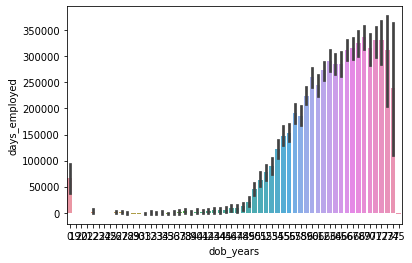

In [12]:
seaborn.barplot(x=data_employed['dob_years'],y=data_employed['days_employed'])

Данные по стажу в зависимости от возраста имеют весьма странный вид (странными являются значения стаже возле нуля, и снижение стажа в правой части графика). Причину этого выясним позже. На данном же этапе отметим наличие разброса значений

Проверим аналогичным образом разброс значений доходов (построим график в зависимости от возраста)

<AxesSubplot:xlabel='dob_years', ylabel='total_income'>

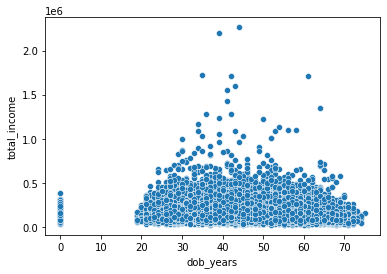

In [13]:
seaborn.scatterplot(x=data_employed['dob_years'],y=data_employed['total_income'])

Виден существенный разброс значеий. Отдельные цифры сильно выходят за пределы общей массы.

Разброс в обоих случаях обосновывает смысл заполнять пустующие ячейки медианными значениями.

Дополнительно отметим что на обоих графиках наблюдаются скопления значений при нулевом значении возраста клиента, с чем предстоит разобраться позднее.

Для начала заполним данные по стажу медианными значениями.
Заполнение пустот и другие операции будем выполнять над копией таблицы (назовём её <code>data_filled</code>), чтобы в случае чего можно было свериться с оригинальной таблицей <code>data_raw</code>

In [14]:
data_filled = data_raw.copy()

In [15]:
print(f"Медианное значение стажа: {data_filled['days_employed'].median()}")

data_filled.loc[ data_filled['days_employed'].isna(),'days_employed'] = data_filled['days_employed'].fillna(data_raw['days_employed'].median())

data_filled.info()
print(f"Стаж min/median/max: {data_raw['days_employed'].min()} / {data_raw['days_employed'].median()} / {data_raw['days_employed'].max()}")

Медианное значение стажа: -1203.369528770489
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   children          21525 non-null  int64  
 1   days_employed     21525 non-null  float64
 2   dob_years         21525 non-null  int64  
 3   education         21525 non-null  object 
 4   education_id      21525 non-null  int64  
 5   family_status     21525 non-null  object 
 6   family_status_id  21525 non-null  int64  
 7   gender            21525 non-null  object 
 8   income_type       21525 non-null  object 
 9   debt              21525 non-null  int64  
 10  total_income      19351 non-null  float64
 11  purpose           21525 non-null  object 
dtypes: float64(2), int64(5), object(5)
memory usage: 2.0+ MB
Стаж min/median/max: -18388.949900568383 / -1203.369528770489 / 401755.40047533


#### total_income - ежемесячный доход

Можно было бы заполнить значения дохода медианным значением, однако же доход 
может сильно зависеть от возраста и образования, попробуем взять не просто медианное
значение, а медианное значение в пределах подгрупп<BR>
Группы по возрасту:
- 18-25 лет
- 26-35 лет
- 36-45 лет
- 46-55 лет
- 55+ лет

Группы по образованию будем брать из столбца <code>education_id</code>

In [16]:
def age_group(age):
    if 18 <= age <=25:
        return 'age18-25'
    if 26 <= age <=35:
        return 'age26-35'
    if 36 <= age <=45:
        return 'age35-45'
    if 46 <= age <=55:
        return 'age46-55'
    if age > 55:
        return 'age55+'
    return 'age_unaccepted'

data_filled['age_group'] = data_filled['dob_years'].apply(age_group)

Заполним значения по группам соответствующими медианами

In [17]:
# Получим сгруппированную табличку медианных значений дохода по группам возраста и образования
income_median_values = data_filled.loc[ data_filled['dob_years'].isna() == False ].groupby(['age_group','education_id'])['total_income'].median()

# Функция, которая будет возвращать нужное медианное значение дохода
def get_income_median_value(row, median_values):
    for age_group, education_id in median_values.index:
        if row['age_group'] == age_group and row['education_id'] == education_id:
            return median_values[ (age_group,education_id) ] 
    return 0 # предполагаем что до возврата нуля дело не дойдёт, так как имеются значения
             # для всех вариантов. Возврат нуля пишем для красоты, как заглушку

# С помощью метода apply() заполняем пустующие ячейки медианными значения дохода для соответствующих подгрупп
# возраста/образования
data_filled.loc[ data_filled['total_income'].isna(),'total_income' ] = data_filled.loc[ data_filled['total_income'].isna() ].apply(get_income_median_value, axis=1, args=(income_median_values,))


### Шаг 2.2 Проверка данных на аномалии и исправления.

#### days_employed - число дней стажа

В столбце <code>days_employed</code> ранее были замечены отрицательные значения, что довольно странно. Посмотрим, сколько таких значений

In [18]:
# Выборка записей со значением стажа выше нуля и ниже нуля
data_plus  = data_filled.loc[ data_filled['days_employed'] > 0].copy()
data_minus = data_filled.loc[ data_filled['days_employed'] < 0].copy()

# Число записей со стажем ниже нуля, выше нуля и с нулевым значением стажа
data_employed_minus = data_minus['days_employed'].count()
data_employed_plus  = data_plus['days_employed'].count()
data_employed_zero  = data_filled.loc[ data_filled['days_employed'] == 0,'days_employed' ].count()

print(f'Значений с со стажем ниже нуля: {data_employed_minus}')
print(f'Значений с со стажем больше нуля: {data_employed_plus}')
print(f'Значений с со стажем равным нулю: {data_employed_zero}')

print("Отношение числа записей со значением стажа ниже нуля по отношению")
print(f'к числу записей со стажем выше нуля: {data_employed_minus/data_employed_plus}')

Значений с со стажем ниже нуля: 18080
Значений с со стажем больше нуля: 3445
Значений с со стажем равным нулю: 0
Отношение числа записей со значением стажа ниже нуля по отношению
к числу записей со стажем выше нуля: 5.248185776487663


In [19]:
data_filled.loc[ data_filled['days_employed'] > 0, 'days_employed' ].mean()

365004.3099162686

In [20]:
data_filled.loc[ data_filled['days_employed'] < 0, 'days_employed' ].mean()

-2214.7785824071443

Получается что отрицательных значений в пять раз больше чем положительных. При этом среднее значение на порядки отличается. Посмотрим, есть ли какая-то связь между значениями стажа и другими столбцами, например с возрастом

<AxesSubplot:xlabel='dob_years', ylabel='days_employed'>

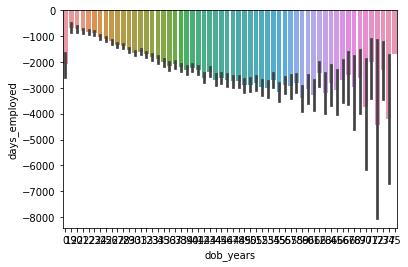

In [21]:
# Для строк с отрицательным стажем
seaborn.barplot(x= data_minus['dob_years'] ,y=data_minus['days_employed' ])


<AxesSubplot:xlabel='dob_years', ylabel='days_employed'>

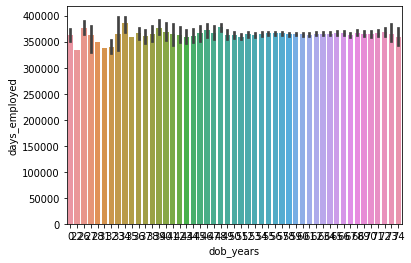

In [22]:
# Для строк с положительным стажем
seaborn.barplot(x= data_plus['dob_years'] ,y=data_plus['days_employed' ])


Попробуем данные с отрицательными значениями сделать положительными, 
а из данных с положительными значениями вычесть минимальное значение

<AxesSubplot:xlabel='dob_years', ylabel='days_employed'>

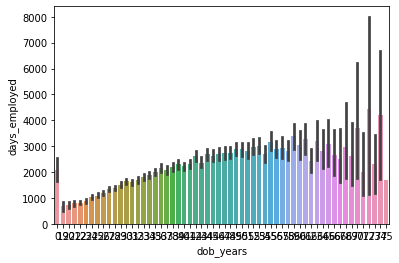

In [23]:
# "отрицательные" значения по модулю
# Для строк с отрицательным стажем
data_minus.loc[:,'days_employed'] = data_minus['days_employed'].abs()
seaborn.barplot(x= data_minus['dob_years'] ,y= data_minus['days_employed' ])


<AxesSubplot:xlabel='dob_years', ylabel='days_employed'>

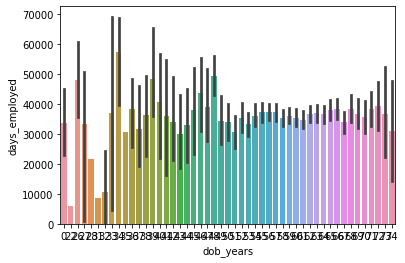

In [24]:
# "положительные" значения с вычитом минимального
data_plus.loc[:,'days_employed'] =data_plus['days_employed'] - data_plus['days_employed'].min()
seaborn.barplot(x= data_plus['dob_years'] ,y= data_plus['days_employed' ])

Судя по виду графика, хотя и есть некоторая тенденция к росту стажа в зависимости от возраста, но всё равно наблюдается дикий разброс значений. Вероятнее всего была какая-то ошибка выгрузки данных по этому столбцу.
Попробуем посмотреть на этот столбец стажа в разрезе пола и вида дохода

In [25]:
# Положительные значения стажа в зависимости от пола
data_plus.groupby('gender')['gender'].count()

gender
F    2807
M     638
Name: gender, dtype: int64

In [26]:
# Отрицательные значения стажа в зависимости от пола
data_minus.groupby('gender')['gender'].count()

gender
F      11429
M       6650
XNA        1
Name: gender, dtype: int64

In [27]:
# Положительные значения стажа в зависимости от типа дохода
data_plus.groupby('income_type')['income_type'].count()

income_type
безработный       2
пенсионер      3443
Name: income_type, dtype: int64

In [28]:
# Отрицательные значения стажа в зависимости от типа дохода
data_minus.groupby('income_type')['income_type'].count()

income_type
в декрете              1
госслужащий         1459
компаньон           5085
пенсионер            413
предприниматель        2
сотрудник          11119
студент                1
Name: income_type, dtype: int64

Похоже что положительные значения относятся в основном к пенсионерам, возможно что имела места ошибка учета стажа в базе данных для клиентов-пенсионеров, либо если данные получали с помощью запроса в пенсионный фонд была ошибка при конвертации/подгрузке данных.
Что же касается отрицательных значений то они выглядят реалистичными, а минус мог возникнуть например если использовали формулу подсчета стажа вида <code>стаж = сегодняшняя_дата - дата_начала_трудовой_деятельности</code>, могли в формуле перепутать даты и вычитать вот так: <code>стаж = дата_начала_трудовой_деятельности - сегодняшняя_дата</code>

In [29]:
data_filled.loc[data_filled['days_employed'] < 0 ]

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose,age_group
0,1,-8437.673028,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875.639453,покупка жилья,age35-45
1,1,-4024.803754,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080.014102,приобретение автомобиля,age35-45
2,0,-5623.422610,33,Среднее,1,женат / замужем,0,M,сотрудник,0,145885.952297,покупка жилья,age26-35
3,3,-4124.747207,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628.550329,дополнительное образование,age26-35
5,0,-926.185831,27,высшее,0,гражданский брак,1,M,компаньон,0,255763.565419,покупка жилья,age26-35
...,...,...,...,...,...,...,...,...,...,...,...,...,...
21519,1,-2351.431934,37,ученая степень,4,в разводе,3,M,сотрудник,0,115949.039788,покупка коммерческой недвижимости,age35-45
21520,1,-4529.316663,43,среднее,1,гражданский брак,1,F,компаньон,0,224791.862382,операции с жильем,age35-45
21522,1,-2113.346888,38,среднее,1,гражданский брак,1,M,сотрудник,1,89672.561153,недвижимость,age35-45
21523,3,-3112.481705,38,среднее,1,женат / замужем,0,M,сотрудник,1,244093.050500,на покупку своего автомобиля,age35-45


Заменим значения для отрицательных ячеек на положительные, а положительные не будем трогать, 
так как нет возможности выяснить подробности, как их интерпретировать

In [30]:
data_filled.loc[data_filled['days_employed'] < 0, 'days_employed' ] = data_filled.loc[ data_filled['days_employed'] < 0,'days_employed' ].abs()

#### children - число детей

Посмотрим, какие варианты значений по числу детей есть с таблице

In [31]:
data_filled['children'].value_counts()

 0     14149
 1      4818
 2      2055
 3       330
 20       76
-1        47
 4        41
 5         9
Name: children, dtype: int64

In [32]:
data_filled.loc[ data_filled['children'] >=20, 'children' ].count() / data_filled[ 'children' ].count()

0.0035307781649245064

С данными по детям в целом всё нормально, хотя есть несколько значений с невероятным числом в 20 детей, а также некоторое число записей с числом детей -1 (минус один). 

Заменим записи с двадцатью детьми на наиболее часто встречающееся значение - ноль.<BR>
А записи с минус одним ребёнком на плюс одного. Вероятно в анкетах был указан дефис, а при переносе анкет 
кто-то из сотрудников на автомате ввел вместо дефиза минус:

In [33]:
data_filled.loc[ data_filled['children'] >=20, 'children' ] = 0
data_filled.loc[ data_filled['children'] ==-1, 'children' ] = 1

#### dob_years - возраст клиента

Проверим значения в столбце возраста. Исходим из предположения что заявки на кредиты принимаются у 
совершеннолетних граждан в возрасте от 18 до 100 лет. Значит значения возраста за пределами этого диапазона
будем считать ошибкой.

In [34]:
data_filled["dob_years"].apply(lambda age: [f"not realistic, age = {age}","realistic"][ 18 < age < 100 ]).value_counts()

realistic                 21424
not realistic, age = 0      101
Name: dob_years, dtype: int64

Есть некорректные значения возраста, при этом во всех таких строках возраст равен нулю. Так как количество таких строк мало и  возраст не является критическим параметром, влияющим на исход задачи - оставляем как есть.

#### education и education_id - образование

In [35]:
data_filled['education'].value_counts()

среднее                13750
высшее                  4718
СРЕДНЕЕ                  772
Среднее                  711
неоконченное высшее      668
ВЫСШЕЕ                   274
Высшее                   268
начальное                250
Неоконченное высшее       47
НЕОКОНЧЕННОЕ ВЫСШЕЕ       29
НАЧАЛЬНОЕ                 17
Начальное                 15
ученая степень             4
Ученая степень             1
УЧЕНАЯ СТЕПЕНЬ             1
Name: education, dtype: int64

In [36]:
data_filled['education_id'].value_counts()

1    15233
0     5260
2      744
3      282
4        6
Name: education_id, dtype: int64

Указанные категории в делятся на:
- начальное
- среднее
- высшее
- неоконченное высшее
- ученая степень

Избавимся от повторяющихся записей, отличающихся только регистром

In [37]:
data_filled.loc[:,'education'] = data_filled['education'].str.lower()
data_filled['education'].value_counts()

среднее                15233
высшее                  5260
неоконченное высшее      744
начальное                282
ученая степень             6
Name: education, dtype: int64

#### family_status

In [38]:
data_filled['family_status'].value_counts()

женат / замужем          12380
гражданский брак          4177
Не женат / не замужем     2813
в разводе                 1195
вдовец / вдова             960
Name: family_status, dtype: int64

In [39]:
data_filled['family_status_id'].value_counts()

0    12380
1     4177
4     2813
3     1195
2      960
Name: family_status_id, dtype: int64

Аномальных значений для столбцов семейного статуса не обнаружено

#### gender - пол клиента

In [40]:
data_filled['gender'].value_counts()

F      14236
M       7288
XNA        1
Name: gender, dtype: int64

За исключением одного значения остальные указаны корректно (мужчина M, либо женщина F). Заменим ошибочное на unknown

In [41]:
data_filled.loc[ (data_filled['gender'] == 'XNA'), 'gender'] = 'unknown'
data_filled['gender'].value_counts()

F          14236
M           7288
unknown        1
Name: gender, dtype: int64

#### debt - наличие задолженности по возврату кредита

In [42]:
data_filled['debt'].value_counts()

0    19784
1     1741
Name: debt, dtype: int64

С данным столбцом проблем не обнаружено

#### total_income - ежемесячный доход

In [43]:
data_filled['total_income'].value_counts()

143784.939634    391
123918.314653    374
136446.558557    371
140704.009565    317
174966.645007    178
                ... 
94270.049769       1
68166.012050       1
124357.256315      1
111976.479710      1
189255.286637      1
Name: total_income, Length: 19361, dtype: int64

Обработка этого столбца не требуется. Повторяющиеся значения являются следствием произведенной ранее замены пустых ячеек.

#### purpose - цель получения кредита

In [44]:
data_filled['purpose'].value_counts()

свадьба                                   797
на проведение свадьбы                     777
сыграть свадьбу                           774
операции с недвижимостью                  676
покупка коммерческой недвижимости         664
покупка жилья для сдачи                   653
операции с жильем                         653
операции с коммерческой недвижимостью     651
жилье                                     647
покупка жилья                             647
покупка жилья для семьи                   641
строительство собственной недвижимости    635
недвижимость                              634
операции со своей недвижимостью           630
строительство жилой недвижимости          626
покупка недвижимости                      624
строительство недвижимости                620
покупка своего жилья                      620
ремонт жилью                              612
покупка жилой недвижимости                607
на покупку своего автомобиля              505
заняться высшим образованием      

Аномальных значений нет, разве что потребуется упростить унифицировать цели в рамках простых категорий. Это будет сделано на следующих этапах.

### Шаг 2.3. Изменение типов данных.

Ещё раз посмотрим базовую информацию по датафрейму.

In [45]:
data_filled.sample(1)

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose,age_group
20379,0,356817.60737,67,среднее,1,Не женат / не замужем,4,F,пенсионер,0,43153.949412,покупка жилья для сдачи,age55+


In [46]:
data_filled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   children          21525 non-null  int64  
 1   days_employed     21525 non-null  float64
 2   dob_years         21525 non-null  int64  
 3   education         21525 non-null  object 
 4   education_id      21525 non-null  int64  
 5   family_status     21525 non-null  object 
 6   family_status_id  21525 non-null  int64  
 7   gender            21525 non-null  object 
 8   income_type       21525 non-null  object 
 9   debt              21525 non-null  int64  
 10  total_income      21525 non-null  float64
 11  purpose           21525 non-null  object 
 12  age_group         21525 non-null  object 
dtypes: float64(2), int64(5), object(6)
memory usage: 2.1+ MB


Нужно заменить типы данных для некоторых столбцов:<BR>
<code>days_employed</code>. Меняем тип float на int, так как дни не должны быть дробными<BR>
<code>total_income</code>. Меняем тип float на int, так как дробная часть не представляет интереса

In [47]:
data_filled['days_employed'] = data_filled['days_employed'].astype('int')
data_filled['total_income'] = data_filled['total_income'].astype('int')

### Шаг 2.4. Удаление дубликатов.

#### Поиск и обработка <u>явных</u> дубликатов

In [48]:
data_filled.loc[ data_filled.duplicated() == True ].sort_values(by=['dob_years','total_income','family_status_id']).head(10)

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose,age_group
20297,1,1203,23,среднее,1,гражданский брак,1,F,сотрудник,0,128240,сыграть свадьбу,age18-25
19321,0,1203,23,среднее,1,Не женат / не замужем,4,F,сотрудник,0,128240,сделка с подержанным автомобилем,age18-25
18328,0,1203,29,высшее,0,женат / замужем,0,M,сотрудник,0,174966,покупка жилой недвижимости,age26-35
6312,0,1203,30,среднее,1,женат / замужем,0,M,сотрудник,0,140704,строительство жилой недвижимости,age26-35
18349,1,1203,30,высшее,0,женат / замужем,0,F,госслужащий,0,174966,покупка жилья для семьи,age26-35
21281,1,1203,30,высшее,0,женат / замужем,0,F,сотрудник,0,174966,покупка коммерческой недвижимости,age26-35
13878,1,1203,31,среднее,1,женат / замужем,0,F,компаньон,0,140704,покупка жилья,age26-35
16904,1,1203,32,высшее,0,женат / замужем,0,F,сотрудник,0,174966,на покупку подержанного автомобиля,age26-35
9238,2,1203,34,среднее,1,женат / замужем,0,F,сотрудник,0,140704,покупка жилья для сдачи,age26-35
4182,1,1203,34,высшее,0,гражданский брак,1,F,сотрудник,0,174966,свадьба,age26-35


Судя по выгрузке данные, запрашиваемые как дубликаты на самом деле отличаются друг от друга. Так что не стоит ничего удалять

### Шаг 2.5. Формирование дополнительных датафреймов словарей, декомпозиция исходного датафрейма.

Выделим образование и семейное положение в отдельные таблицы

In [49]:
data_education_dict     = data_filled[['education','education_id']].drop_duplicates().reset_index(drop=True)
data_family_status_dict = data_filled[['family_status','family_status_id']].drop_duplicates().reset_index(drop=True)


Удалим текстовые столбцы из оригинальной таблицы <code>data_filled</code>, оставив только индексы. Это позволит уменьшить расход памяти и увеличить скорость работы операций с таблицей.

In [50]:
data_filled = data_filled.drop(columns=['family_status','education'])

### Шаг 2.6. Категоризация дохода.

Запишем метод <code>get_income_category</code>, применив который к таблице мы сможем получить столбец <code>total_income_category</code>,<BR>
позволяющий группировать клиентов по группам дохода

In [51]:
def get_income_category(income_value):
    if    0 <= income_value <= 30000:
        return 'E'
    if 30000 < income_value <= 50000:
        return 'D'
    if 50000 < income_value <= 200000:
        return 'C'
    if 200000< income_value <= 1000000:
        return 'B'
    if income_value > 1000000:
        return 'A'
    return 'error'

In [52]:
data_filled['total_income_category'] = data_filled['total_income'].apply(get_income_category)

### Шаг 2.7. Категоризация целей кредита.

Добавим функцию, выдающую категорию целей на основе значения цели <code>purpose</code> из таблицы

In [53]:
def get_purpose_category(purpose):
    # Автомобиль
    if  re.search('автомо',purpose) or \
        re.search('машин',purpose)  or \
        re.search('транспорт.*средств',purpose):
        return 'операции с автомобилем'
    
    # Недвижимость
    if  re.search('жиль',purpose) or \
        re.search('недвиж',purpose):
        return 'операции с недвижимостью'
    
    # Свадьба
    if  re.search('свадьб',purpose) or \
        re.search('свадеб',purpose) or \
        re.search('женить',purpose):
        return 'проведение свадьбы'    
    
    # Образование
    if  re.search('образов',purpose):
        return 'получение образования'
    
    # на случай ошибки или плохой фильтрации
    return 'error'

Применим функцию к таблице для получения нового столбца <code>purpose_category</code>

In [54]:
data_filled['purpose_category'] = data_filled['purpose'].apply(get_purpose_category)

Проверим корректность результата

In [55]:
data_filled['purpose_category'].value_counts()

операции с недвижимостью    10840
операции с автомобилем       4315
получение образования        4022
проведение свадьбы           2348
Name: purpose_category, dtype: int64

### Ответы на вопросы.

##### Вопрос 1:

Есть ли зависимость между количеством детей и возвратом кредита в срок?

Расчет:

Посчитаем число своевременных и несвоевременных погашений с помощью сводной таблицы и выведем её

In [56]:
# Сводная таблица:
data_pivot_children = data_filled.pivot_table(index   = 'children',   \
                                              columns = 'debt',        \
                                              values  = 'dob_years',   \
                                              aggfunc = 'count').fillna(0)

#Переименуем столбцы
data_pivot_children = data_pivot_children.rename(columns={0:'no_debts',1:'debts'})

# Добавим новый столбец, равный индексу. А в индексе у нас число детей
data_pivot_children['children'] = data_pivot_children.index

# Отношение числа клиентов с задолженностями по отношению к числу без задолженностей при текущем числе детей
data_pivot_children['debt_ratio'] = data_pivot_children['no_debts'] / data_pivot_children['debts']

# Процент числа клиентов с задолженностями при указанном числе детей
data_pivot_children['debt_percentage'] = round(100* data_pivot_children['debts']       \
                                               / (  data_pivot_children['no_debts'] + data_pivot_children['debts']), 2)

data_pivot_children.sort_values(by='debt_percentage')

debt,no_debts,debts,children,debt_ratio,debt_percentage
children,,,,,
5,9.0,0.0,5,inf,0.00
0,13154.0,1071.0,0,12.281979,7.53
3,303.0,27.0,3,11.222222,8.18
1,4420.0,445.0,1,9.932584,9.15
2,1861.0,194.0,2,9.592784,9.44
4,37.0,4.0,4,9.250000,9.76


Результат показывает что отсутствие детей в целом скорее говорит о более вероятной просрочке кредита. Результат с 5 детьми не рассматриваем так как при имеющейся статистике не было задолженностей у клиентов с этим числом детей.

In [57]:
no_debts_no_children, debts_no_children = data_pivot_children.loc[ data_pivot_children['children'] == 0,'no_debts'].sum(), \
                                          data_pivot_children.loc[ data_pivot_children['children'] == 0,'debts'].sum()
no_debts_children,    debts_children    = data_pivot_children.loc[ data_pivot_children['children'] >  0,'no_debts'].sum(), \
                                          data_pivot_children.loc[ data_pivot_children['children'] >  0,'debts'].sum()

In [58]:
print(f"Процент просрочек у бездетных клиентов: {debts_no_children / (debts_no_children + no_debts_no_children):.2%}")
print(f"Процент просрочек у клиентов с детьми: {debts_children / (debts_children + no_debts_children):.2%}")

Процент просрочек у бездетных клиентов: 7.53%
Процент просрочек у клиентов с детьми: 9.18%


##### Ответ 1:

Вывод: наличие детей немного увеличивает вероятность несвоевременного возврата. Примерно на 1.65%.

##### Вопрос 2:

Есть ли зависимость между семейным положением и возвратом кредита в срок?

Расчет:

In [59]:
# Сделаем сводную табличку зависимости задолженностей от семейного статуса
d_pivot_family_status = data_filled.pivot_table(index   = 'family_status_id', \
                                                columns = 'debt',             \
                                                values  = 'dob_years',        \
                                                aggfunc = 'count')

d_pivot_family_status['family_status_id'] = d_pivot_family_status.index # Вынесем ID статуса из индекса в столбец
d_pivot_family_status = d_pivot_family_status.reset_index(drop=True)

# Для наглядности переименуем индикатор наличия задолженности
d_pivot_family_status = d_pivot_family_status.rename(columns={0:'no_debt',1:'debt'}) 

# Для наглядности подгрузим наименования семейных статусов из созданной ранее таблички
d_pivot_family_status = d_pivot_family_status.merge(data_family_status_dict,on='family_status_id',how='left')

# Уберём столбец с идентификатором семейного статуса. Для наглядного представления таблицы он уже не нужен
d_pivot_family_status = d_pivot_family_status.drop(columns='family_status_id')

# Посчитаем процентное соотношение клиентов с задолженнсотями в подгруппе семейного статуса
d_pivot_family_status['debt_percentage'] = round(100*d_pivot_family_status['debt'] / (d_pivot_family_status['debt']+d_pivot_family_status['no_debt']),2)

# Отсортируем по росту задолженности и посмотрим что получилось
d_pivot_family_status.sort_values(by='debt_percentage')


,no_debt,debt,family_status,debt_percentage
2,897,63,вдовец / вдова,6.56
3,1110,85,в разводе,7.11
0,11449,931,женат / замужем,7.52
1,3789,388,гражданский брак,9.29
4,2539,274,Не женат / не замужем,9.74


##### Ответ 2:

Вывод: Есть зависимость между семейным статусом и несвоевременными уплатами кредитов. Если клиент не вступал в брак то вероятность несвоевременной оплаты кредита выше на 2.22% чем у тех кто в данный момент состоит в браке.
Наименьший процент проблемных кредитов у вдовец/вдовцов и у разведённых.

##### Вопрос 3:

Есть ли зависимость между уровнем дохода и возвратом кредита в срок?

Расчет:

In [60]:
# Сделаем небольшой словарик по доходам для наглядности
income_categories_df = pd.DataFrame(data={'income_category':['E','D','C','B','A'], \
                                          'income_range'   :['0-30000',            \
                                                             '30001-50000',        \
                                                             '50001-200000',       \
                                                             '200001-1000000',     \
                                                             '1000000+'] } )

# Построим сводную табличку
d_pivot_income = data_filled.pivot_table(index='total_income_category',columns='debt',values='dob_years',aggfunc='count')

# "Облагородим" табличку для увеличения наглядности и добавим процент клиентов с несвоевременной оплатой
d_pivot_income = d_pivot_income.rename(columns={0:'no_debt',1:'debt'})
d_pivot_income['income_category'] = d_pivot_income.index # Выносим категории дохода в отдельный столбец из индекса
d_pivot_income = d_pivot_income.reset_index(drop=True)   # Индекс удаляем
d_pivot_income = d_pivot_income.merge(income_categories_df,on='income_category',how='left')
d_pivot_income['debt_percentage'] = round(100*d_pivot_income['debt'] / (d_pivot_income['debt']+d_pivot_income['no_debt']),2)

# Отсортируем по проценту проблемных кредитов и посмотрим на результат
d_pivot_income.sort_values(by='debt_percentage')


,no_debt,debt,income_category,income_range,debt_percentage
3,329,21,D,30001-50000,6.00
1,4685,356,B,200001-1000000,7.06
0,23,2,A,1000000+,8.00
2,14727,1360,C,50001-200000,8.45
4,20,2,E,0-30000,9.09


##### Ответ 3:

Табличка с результатами показывает что наиболее "безопасная" в плане своевременного погашения
кредитов группа - люди с доходами от 30 до 50 тыс.руб., а наиболее рискованная - с доходами до 30 тыс.руб. в месяц. Однако сложно назвать выборку полноценно репрезентативной для оценки рисков по группам A и E, так как число кредитов в этих подгруппах очень мало по отношению к общей массе.


##### Вопрос 4:

Как разные цели кредита влияют на его возврат в срок?

Расчет:

In [61]:
# Построим сводную табличку
d_pivot_purpose = data_filled.pivot_table(index='purpose_category',columns='debt',values='dob_years',aggfunc='count')
d_pivot_purpose = d_pivot_purpose.rename(columns={0:'no_debt',1:'debt'})

# Добавим столбец с процентами
d_pivot_purpose['debt_percentage'] = round(  100*d_pivot_purpose['debt']/(d_pivot_purpose['debt']+d_pivot_purpose['no_debt']), 2)

# Упорядочим по процентам невозврата и посмотрим на результат
d_pivot_purpose.sort_values(by='debt_percentage')

debt,no_debt,debt,debt_percentage
purpose_category,,,
операции с недвижимостью,10058,782,7.21
проведение свадьбы,2162,186,7.92
получение образования,3652,370,9.20
операции с автомобилем,3912,403,9.34


##### Ответ 4:

Вывод: наиболее безопасными с точки зрения возврата кредита (на основе имеющейся выборки) являются кредиты, выдаваемые на операции с недвижимостью.<BR>Наименее безопасными - автокредиты.

## Общий вывод:

На основе предоставленной выборки обнаружена связь перечисленных в гипотезе факторов, влияющих на своевременное погашение кредитов, а именно:<BR>
- наличие детей
- общий доход
- семейное положение
- цель получения кредита

В среднем каждый из факторов статистически связан с влиянием на вероятность своевременного погашения кредита примерно на 2 - 3%.

Наиболее безопасные с точки зрения возврата кредита - кредиты, выдаваемые: <BR>
- на операции с недвижимостью
- клиентам с доходом между 30 и 50 тысячами рублей в месяц
- клиентам, не имеющим детей
- клиентам, являющимся вдовами/вдовцами, либо находящимся в разводе

Более "рискованными" являются кредиты, выдаваемыме:<BR>
- клиентам с доходами до 30 тыс. руб. в месяц
- на операции, связанные с автомобилями
- клиентам у которых есть четверо детей
- клиентам которые ещё не вышли замуж / не женились)